## Lab 3: Dealing with Unlabeled Data
XBUS-511: Diagnostics for More Informed Machine Learning

In this exercise, we will be performing an unsupervised analysis of the Severe Injury Reports from the Occupational Safety and Health Administration.

OSHA requires employers to report all severe work-related injuries, defined as an amputation, in-patient hospitalization, or loss of an eye. The requirement began on January 1, 2015. This dataset provides information from those reports, including a description of the incident and the name and address of the establishment where it happened. Injuries are coded using the Occupational Injury and Illness Classification System.

Visit OSHA for more information about the [Severe Injury Reports table](https://www.osha.gov/severeinjury/).

## Imports

In [1]:
import os
import requests
import pandas as pd

from sklearn.cluster import KMeans

from yellowbrick.features import PCA, Manifold
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance


## Fetch the Data

In [2]:
# Make sure the fixtures path exists
FIXTURES = os.path.join("..", "fixtures")
if not os.path.exists(FIXTURES):
    os.makedirs(FIXTURES)

In [3]:
def fetch_data(url, fname):
    """
    Helper method to retrieve data.
    """
    response = requests.get(url)
    outpath  = os.path.abspath(fname)
    with open(outpath, "wb") as f:
        f.write(response.content)
    
    return outpath

In [4]:
# Fetch and unzip the data
URL = "https://www.osha.gov/severeinjury/xml/severeinjury.csv"
FILE_NAME = "severeinjury.csv"

raw_data = fetch_data(
    URL, 
    os.path.join(FIXTURES, FILE_NAME)
)

In [5]:
incidents_df = pd.read_csv(
    os.path.join(
        FIXTURES, 
        FILE_NAME
    ),
    engine="python"
)

incidents_df = incidents_df.dropna()
incidents_df.describe()

,ID,UPA,Zip,Latitude,Longitude,Hospitalized,Amputation,Inspection,Nature,Part of Body,Event,Source,Secondary Source
count,5.220000e+02,5.220000e+02,522.000000,522.000000,522.000000,522.000000,522.000000,5.220000e+02,522.000000,522.000000,522.000000,522.000000,522.000000
mean,5.184095e+09,1.312359e+06,45442.471264,35.711897,-85.952107,0.911877,0.149425,1.300322e+06,691.862069,1608.812261,4162.091954,4819.764368,4813.833333
std,6.897626e+09,1.768536e+05,25031.600287,5.843905,21.213503,0.327693,0.356849,1.248832e+05,741.697917,2607.613188,1944.370776,2874.349100,3164.062432
min,2.015010e+09,9.304780e+05,802.000000,13.380000,-158.060000,0.000000,0.000000,1.017766e+06,10.000000,6.000000,40.000000,10.000000,10.000000
25%,2.017011e+09,1.171269e+06,26363.250000,30.485000,-94.655000,1.000000,0.000000,1.203010e+06,111.000000,111.000000,4213.000000,2452.750000,2118.000000
50%,2.018089e+09,1.354478e+06,36545.000000,36.830000,-84.410000,1.000000,0.000000,1.330762e+06,132.000000,483.000000,4332.000000,4429.000000,4415.000000
75%,2.020010e+09,1.449800e+06,70101.500000,40.420000,-80.142500,1.000000,0.000000,1.398242e+06,1311.000000,899.000000,6232.500000,6694.750000,7293.000000
max,2.019121e+10,1.596321e+06,96915.000000,48.340000,144.780000,2.000000,1.000000,1.477374e+06,2361.000000,9999.000000,6419.000000,9999.000000,9999.000000


In [6]:
incidents_df.head()

,ID,UPA,EventDate,Employer,Address1,Address2,City,State,Zip,Latitude,...,Nature,NatureTitle,Part of Body,Part of Body Title,Event,EventTitle,Source,SourceTitle,Secondary Source,Secondary Source Title
105,2015010139,930478,1/6/2015,Strata Concrete Corporation,Highway 23 to 89th Avenue South 2.3 miles,Gold Star Site,NEW TOWN,NORTH DAKOTA,58763.0,47.99,...,1510,"Chemical burns and corrosions, unspecified",130,"Face, unspecified",5544,"Exposure through intact skin, eyes, or other e...",1115,Sulfuric acid,3991.0,Air compressors
214,2015010309,931164,1/9/2015,Capital Steel and Iron,SW 15th and Agnew,Site EE Superviosr Ulyssses Alonzo,OKLAHOMA CITY,OKLAHOMA,73108.0,35.44,...,1520,"Heat (thermal) burns, unspecified",899,"Multiple body parts, n.e.c.",317,"Ignition of vapors, gases, or liquids",1643,Propane,3430.0,"Cranes, unspecified"
284,2015010393,931820,1/12/2015,"Chancellor, Inc.",Entergy Willow Glenn 500 KV Substation,"2605 Hwy, LA 75",SAINT GABRIEL,LOUISIANA,70776.0,30.28,...,1533,Third or fourth degree electrical burns,9999,Nonclassifiable,5112,"Direct exposure to electricity, greater than 2...",7199,"Handtools-nonpowered, n.e.c.",4417.0,"Switchboards, switches, fuses"
477,2015010597,933114,1/19/2015,"Zeco Equipment, LLC",Longitude 48.06.00 North /Latitude 102.28.042 ...,"South of Stanley, North Dakota",STANLEY,NORTH DAKOTA,58784.0,48.34,...,1972,"Soreness, pain, hurt-nonspecified injury",320,"Back, including spine, spinal cord, unspecified",6233,Struck by object falling from vehicle or machi...,219,"Containers, n.e.c.",8621.0,"Forklift, order picker, platform truck-powered"
490,2015010612,933379,1/20/2015,"Infinity Maintenance Servies, LP","Oyster Creek Site, Unit 3",2301 North Brazosport Blvd.,FREEPORT,TEXAS,77541.0,28.97,...,1972,"Soreness, pain, hurt-nonspecified injury",10,"Head, unspecified",649,Caught in or compressed by equipment or object...,3467,"Aerial lifts, scissor lifts-except truck-mounted",6551.0,"Girders, beams, structural steel"


In [7]:
numeric_fields = [
    "Zip", "Latitude", "Longitude", "Hospitalized", 
    "Amputation", "Inspection", "Nature", "Part of Body"
]

In [8]:
X = incidents_df[numeric_fields]

## Let's see if we can build a spherical model

The [KElbowVisualizer](https://www.scikit-yb.org/en/develop/api/cluster/elbow.html) implements the “elbow” method to help data scientists select the optimal number of clusters by fitting the model with a range of values for 𝐾. If the line chart resembles an arm, then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point. In the visualizer “elbow” will be annotated with a dashed line.

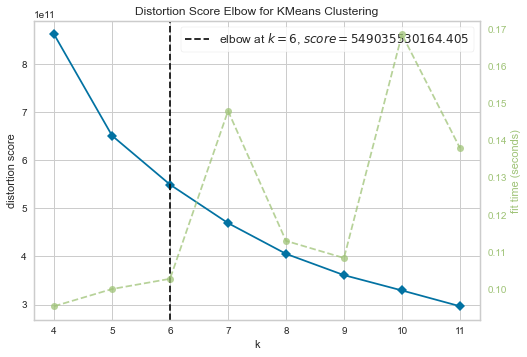

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
visualizer = KElbowVisualizer(KMeans(), k=(4,12))
visualizer.fit(X)
visualizer.show()

The Silhouette Coefficient is used when the ground-truth about the dataset is unknown and computes the density of clusters computed by the model. The score is computed by averaging the silhouette coefficient for each sample, computed as the difference between the average intra-cluster distance and the mean nearest-cluster distance for each sample, normalized by the maximum value. This produces a score between 1 and -1, where 1 is highly dense clusters and -1 is completely incorrect clustering.

The [Silhouette Visualizer](https://www.scikit-yb.org/en/develop/api/cluster/silhouette.html) displays the silhouette coefficient for each sample on a per-cluster basis, visualizing which clusters are dense and which are not. This is particularly useful for determining cluster imbalance, or for selecting a value for 𝐾 by comparing multiple visualizers.

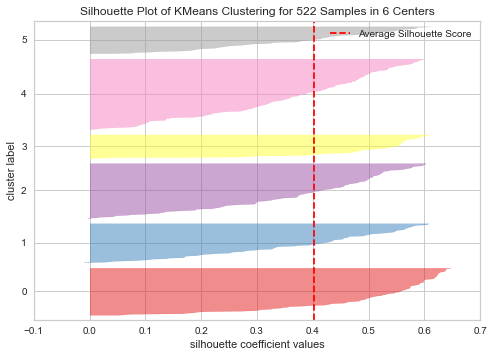

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 522 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [10]:
model = KMeans(6, random_state=38)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(X)
visualizer.show()

[Intercluster distance maps](https://www.scikit-yb.org/en/develop/api/cluster/icdm.html) display an embedding of the cluster centers in 2 dimensions with the distance to other centers preserved. E.g. the closer to centers are in the visualization, the closer they are in the original feature space. The clusters are sized according to a scoring metric. By default, they are sized by membership, e.g. the number of instances that belong to each center. This gives a sense of the relative importance of clusters. Note however, that because two clusters overlap in the 2D space, it does not imply that they overlap in the original feature space.

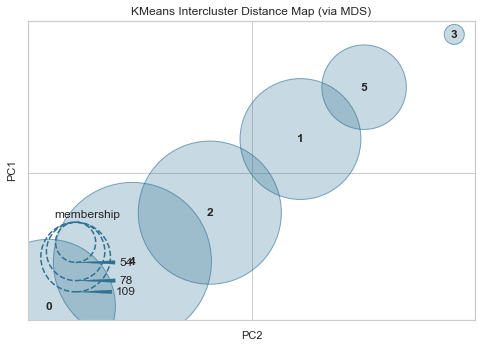

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [11]:
visualizer = InterclusterDistance(model)

visualizer.fit(X)
visualizer.show()

## Create a "cluster label" column

In [12]:
incidents_df["cluster"] = pd.Series(
    model.labels_, index=incidents_df.index
)

## Do the clusters make sense?

Let's pick a few clusters and dive in; what do incidents inside the same cluster seem to have in common? Why do you think they fall into a group?

In [13]:
cluster_zero = incidents_df.loc[incidents_df["cluster"] == 0]
cluster_zero.head()

,ID,UPA,EventDate,Employer,Address1,Address2,City,State,Zip,Latitude,...,NatureTitle,Part of Body,Part of Body Title,Event,EventTitle,Source,SourceTitle,Secondary Source,Secondary Source Title,cluster
46225,2019067864,1497926,6/4/2019,Dynalectric Co. Florida,164 NE 2nd.Ave.,Block D,MIAMI,FLORIDA,33132.0,25.77,...,Fractures,899,"Multiple body parts, n.e.c.",4312,Fall from collapsing structure or equipment 6 ...,7422,Step ladders,6629.0,"Floor, n.e.c.",0
47661,2019077400,1478434,7/19/2019,BTC Builders Inc.,Oaks at Shannon's Crossing,833 US 441,OKEECHOBEE,FLORIDA,34974.0,27.20,...,Fractures,899,"Multiple body parts, n.e.c.",4332,Other fall to lower level 6 to 10 feet,6540,"Roofs, unspecified",2236.0,"Tables, worktables",0
47766,2019077526,1479868,7/23/2019,"APTIV Services US, LLC",1265 North River Road,M/S 11A,WARREN,OHIO,44483.0,41.26,...,Fractures,310,"Chest, except internal location of diseases or...",4330,"Other fall to lower level, unspecified",6692,"Ramps, loading docks, dock plates",660.0,"Floors, walkways, ground surfaces, unspecified",0
47921,2019077705,1487452,7/29/2019,"Aspen Rayn Enterprises, LLC",Pine Tree Lodge,3296 Pine Tree Road,BEAUMONT,TEXAS,77705.0,29.87,...,Internal injuries to organs and blood vessels ...,38,Multiple trunk locations,4335,Other fall to lower level 21 to 25 feet,6540,"Roofs, unspecified",4415.0,"Power lines, transformers, convertors",0
47928,2019077714,1482624,7/29/2019,NEXCOM,Navy Exchange JEB Little Creek - Fort Story,Gate 1 Mini-Mart,VIRGINIA BEACH,VIRGINIA,23459.0,36.90,...,Fractures,52,Ankle(s),4331,Other fall to lower level less than 6 feet,7422,Step ladders,6629.0,"Floor, n.e.c.",0


In [14]:
cluster_three = incidents_df.loc[incidents_df["cluster"] == 3]
cluster_three.head()

,ID,UPA,EventDate,Employer,Address1,Address2,City,State,Zip,Latitude,...,NatureTitle,Part of Body,Part of Body Title,Event,EventTitle,Source,SourceTitle,Secondary Source,Secondary Source Title,cluster
105,2015010139,930478,1/6/2015,Strata Concrete Corporation,Highway 23 to 89th Avenue South 2.3 miles,Gold Star Site,NEW TOWN,NORTH DAKOTA,58763.0,47.99,...,"Chemical burns and corrosions, unspecified",130,"Face, unspecified",5544,"Exposure through intact skin, eyes, or other e...",1115,Sulfuric acid,3991.0,Air compressors,3
214,2015010309,931164,1/9/2015,Capital Steel and Iron,SW 15th and Agnew,Site EE Superviosr Ulyssses Alonzo,OKLAHOMA CITY,OKLAHOMA,73108.0,35.44,...,"Heat (thermal) burns, unspecified",899,"Multiple body parts, n.e.c.",317,"Ignition of vapors, gases, or liquids",1643,Propane,3430.0,"Cranes, unspecified",3
284,2015010393,931820,1/12/2015,"Chancellor, Inc.",Entergy Willow Glenn 500 KV Substation,"2605 Hwy, LA 75",SAINT GABRIEL,LOUISIANA,70776.0,30.28,...,Third or fourth degree electrical burns,9999,Nonclassifiable,5112,"Direct exposure to electricity, greater than 2...",7199,"Handtools-nonpowered, n.e.c.",4417.0,"Switchboards, switches, fuses",3
477,2015010597,933114,1/19/2015,"Zeco Equipment, LLC",Longitude 48.06.00 North /Latitude 102.28.042 ...,"South of Stanley, North Dakota",STANLEY,NORTH DAKOTA,58784.0,48.34,...,"Soreness, pain, hurt-nonspecified injury",320,"Back, including spine, spinal cord, unspecified",6233,Struck by object falling from vehicle or machi...,219,"Containers, n.e.c.",8621.0,"Forklift, order picker, platform truck-powered",3
490,2015010612,933379,1/20/2015,"Infinity Maintenance Servies, LP","Oyster Creek Site, Unit 3",2301 North Brazosport Blvd.,FREEPORT,TEXAS,77541.0,28.97,...,"Soreness, pain, hurt-nonspecified injury",10,"Head, unspecified",649,Caught in or compressed by equipment or object...,3467,"Aerial lifts, scissor lifts-except truck-mounted",6551.0,"Girders, beams, structural steel",3


## Explore Linear Relationships

We can use [PCA](https://www.scikit-yb.org/en/develop/api/features/pca.html) to explore relationships within and across our clusters 

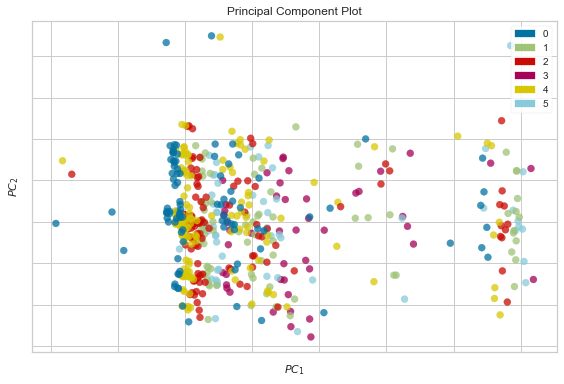

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [15]:
# PCA Decomposition
y = incidents_df["cluster"].values

visualizer = PCA(scale=True)
visualizer.fit_transform(X, y)
visualizer.show()


What relationships do you see?


## What about a more complex embedding space?

The [Manifold visualizer](https://www.scikit-yb.org/en/develop/api/features/manifold.html) provides high dimensional visualization using manifold learning to embed instances described by many dimensions into 2, thus allowing the creation of a scatter plot that shows latent structures in data. Unlike decomposition methods such as PCA and SVD, manifolds generally use nearest-neighbors approaches to embedding, allowing them to capture non-linear structures that would be otherwise lost. The projections that are produced can then be analyzed for noise or separability to determine if it is possible to create a decision space in the data.

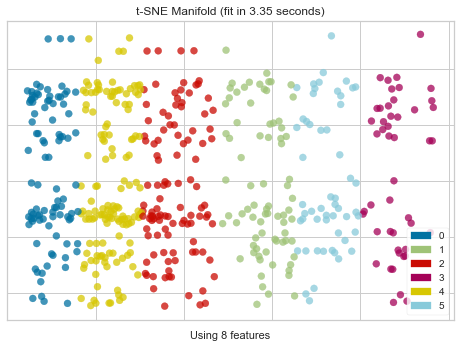

<AxesSubplot:title={'center':'t-SNE Manifold (fit in 3.35 seconds)'}, xlabel='Using 8 features'>

In [16]:
# Manifold visualizer
viz = Manifold(manifold="tsne")

viz.fit_transform(X, y)
viz.show()

What patterns do you see?  What would be your next steps?